# Physics Analysis: Wind Power Equation

This notebook analyzes the relationship between theoretical physics-based power predictions and actual SCADA measurements.


In [3]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root / 'src'))

from physics_constraints import (
    wind_power_equation,
    compute_physics_residual,
    analyze_power_curve_regions
)

# Ensure results directories exist
(project_root / 'results' / 'figures').mkdir(parents=True, exist_ok=True)
(project_root / 'results' / 'metrics').mkdir(parents=True, exist_ok=True)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## Load Processed Data


In [4]:
# Load cleaned data
# Check for both compressed and uncompressed versions
data_path_csv = project_root / 'data' / 'processed' / 'scada_cleaned.csv'
data_path_gz = project_root / 'data' / 'processed' / 'scada_cleaned.csv.gz'
mapping_path = project_root / 'data' / 'processed' / 'feature_mapping.json'

# Determine which file exists
if data_path_gz.exists():
    print(f"Loading compressed data from: {data_path_gz}")
    df = pd.read_csv(data_path_gz, index_col=0, parse_dates=True, compression='gzip')
elif data_path_csv.exists():
    print(f"Loading data from: {data_path_csv}")
    df = pd.read_csv(data_path_csv, index_col=0, parse_dates=True)
else:
    raise FileNotFoundError(
        f"Cleaned data file not found!\n"
        f"Expected one of:\n"
        f"  - {data_path_csv}\n"
        f"  - {data_path_gz}\n\n"
        f"Please run notebook 01_data_exploration.ipynb first to generate the cleaned data."
    )

# Load feature mapping
if not mapping_path.exists():
    raise FileNotFoundError(
        f"Feature mapping file not found: {mapping_path}\n"
        f"Please run notebook 01_data_exploration.ipynb first."
    )

with open(mapping_path, 'r') as f:
    feature_mapping = json.load(f)

print(f"\nLoaded {len(df):,} samples")
print(f"Target: {feature_mapping['target']}")
print(f"Wind speed column: {feature_mapping['all_features'].get('wind_speed', 'N/A')}")

Loading compressed data from: D:\mini project\data\processed\scada_cleaned.csv.gz


C:\Users\Pavan\AppData\Local\Temp\ipykernel_26056\2534852472.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(data_path_gz, index_col=0, parse_dates=True, compression='gzip')



Loaded 37,244,084 samples
Target: PowerOutput
Wind speed column: WindSpeed


## Wind Power Equation

The theoretical power output follows:

**P = 0.5 × ρ × A × Cp × v³**

Where:
- ρ (rho) = air density (kg/m³)
- A = rotor swept area (m²)
- Cp = power coefficient (dimensionless, max ~0.59)
- v = wind speed (m/s)


In [5]:
# Get wind speed and power columns
ws_col = feature_mapping['all_features'].get('wind_speed')
power_col = feature_mapping['target']

if not ws_col or ws_col not in df.columns:
    print("⚠️  Wind speed column not found. Please check feature mapping.")
else:
    # Compute theoretical power
    wind_speed = df[ws_col].values
    actual_power = df[power_col].values
    
    # Adjust parameters based on actual turbine (may need tuning)
    theoretical_power = wind_power_equation(
        wind_speed,
        air_density=1.225,  # kg/m³
        rotor_area=5026.55,  # m² (80m diameter)
        power_coefficient=0.4,
        cut_in_speed=3.0,
        rated_speed=12.0,
        rated_power=2000.0,
        cut_out_speed=25.0
    )
    
    # Add to dataframe
    df['theoretical_power'] = theoretical_power
    df['physics_residual'] = compute_physics_residual(actual_power, theoretical_power)
    
    print("Theoretical power computed")
    print(f"  Mean theoretical: {theoretical_power.mean():.2f} kW")
    print(f"  Mean actual: {actual_power.mean():.2f} kW")
    print(f"  Mean residual: {df['physics_residual'].mean():.2f} kW")


Theoretical power computed
  Mean theoretical: 65.50 kW
  Mean actual: 1.08 kW
  Mean residual: -64.42 kW


## Theoretical vs Actual Power


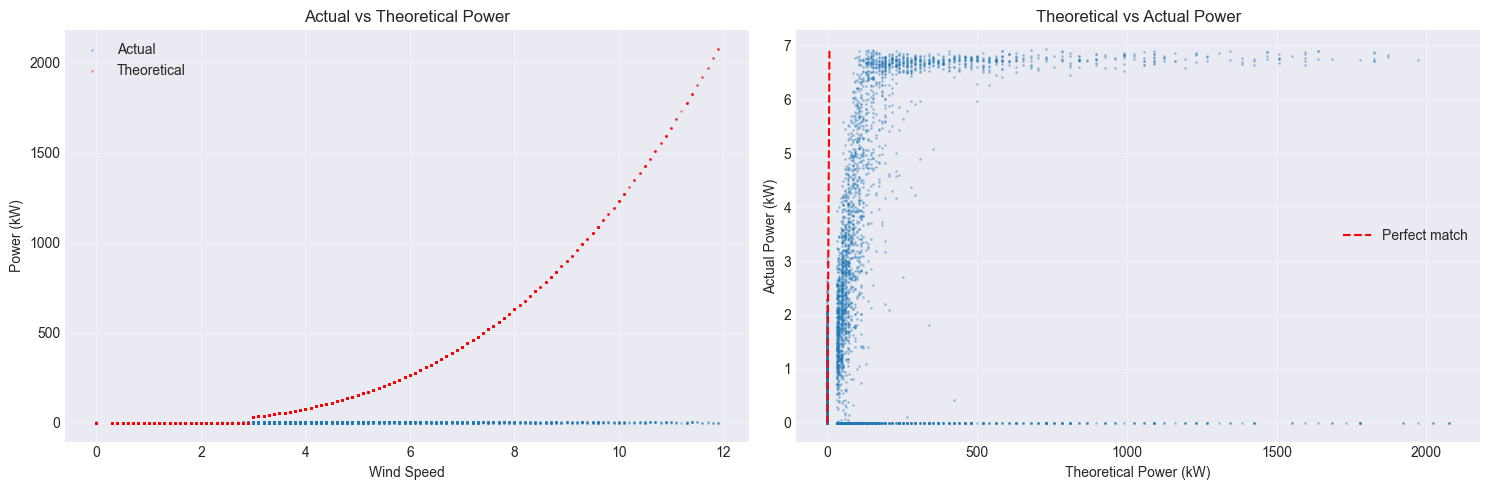

In [6]:
# Compare theoretical vs actual
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(df_sample[ws_col], df_sample[power_col], alpha=0.3, s=1, label='Actual')
axes[0].scatter(df_sample[ws_col], df_sample['theoretical_power'], alpha=0.3, s=1, label='Theoretical', color='red')
axes[0].set_xlabel('Wind Speed')
axes[0].set_ylabel('Power (kW)')
axes[0].set_title('Actual vs Theoretical Power')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Direct comparison
axes[1].scatter(df_sample['theoretical_power'], df_sample[power_col], alpha=0.3, s=1)
axes[1].plot([0, df_sample[power_col].max()], [0, df_sample[power_col].max()], 'r--', label='Perfect match')
axes[1].set_xlabel('Theoretical Power (kW)')
axes[1].set_ylabel('Actual Power (kW)')
axes[1].set_title('Theoretical vs Actual Power')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
figures_dir = project_root / 'results' / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'theoretical_vs_actual.png', dpi=150)
plt.show()


## Power Curve Regions Analysis


In [7]:
# Analyze power curve regions
regions_stats = analyze_power_curve_regions(
    df[ws_col].values,
    df[power_col].values,
    cut_in=3.0,
    rated=12.0,
    cut_out=25.0
)

print("Power Curve Region Statistics:")
for region, stats in regions_stats.items():
    if stats['count'] > 0:
        print(f"\n{region.upper()}:")
        print(f"  Count: {stats['count']:,}")
        print(f"  Mean Power: {stats['mean_power']:.2f} kW")
        print(f"  Mean Wind Speed: {stats['mean_wind_speed']:.2f} m/s")
        print(f"  Power Range: [{stats['min_power']:.2f}, {stats['max_power']:.2f}] kW")


Power Curve Region Statistics:

BELOW_CUTIN:
  Count: 26,314,111
  Mean Power: 0.21 kW
  Mean Wind Speed: 1.35 m/s
  Power Range: [0.00, 6.32] kW

OPERATIONAL:
  Count: 10,929,973
  Mean Power: 3.18 kW
  Mean Wind Speed: 4.94 m/s
  Power Range: [0.00, 7.31] kW


## Physics Residual Analysis


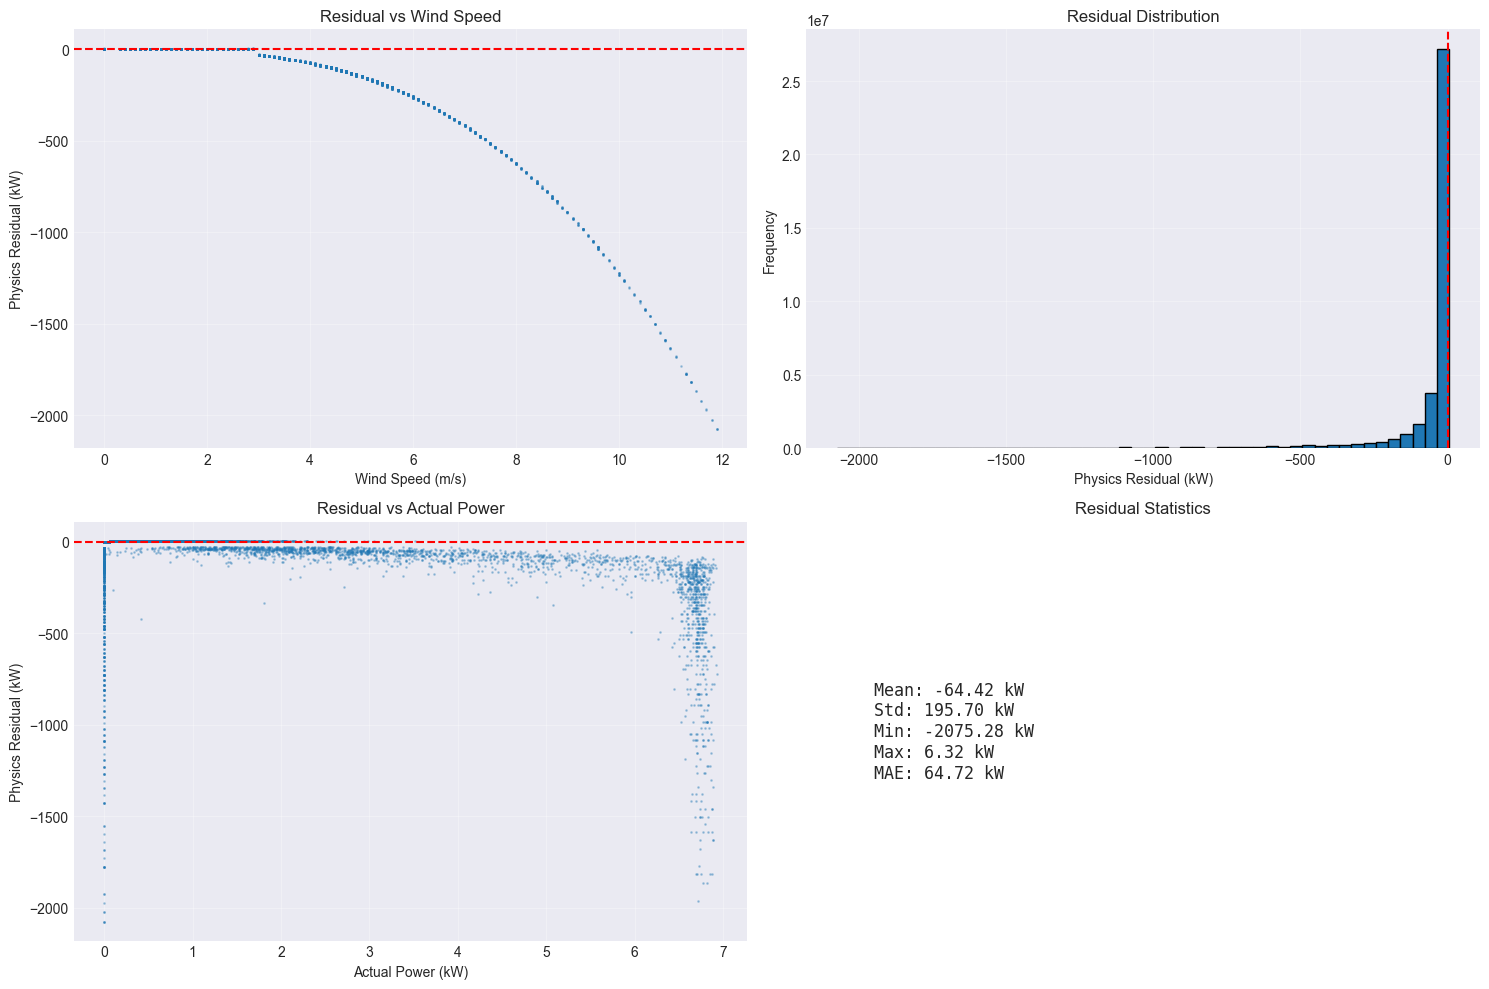


Physics Residual Statistics:
  Mean: -64.42 kW
  Std: 195.70 kW
  Min: -2075.28 kW
  Max: 6.32 kW
  MAE: 64.72 kW


In [8]:
# Analyze physics residual
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residual vs wind speed
axes[0, 0].scatter(df_sample[ws_col], df_sample['physics_residual'], alpha=0.3, s=1)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Wind Speed (m/s)')
axes[0, 0].set_ylabel('Physics Residual (kW)')
axes[0, 0].set_title('Residual vs Wind Speed')
axes[0, 0].grid(True, alpha=0.3)

# Residual distribution
axes[0, 1].hist(df['physics_residual'], bins=50, edgecolor='black')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Physics Residual (kW)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Residual vs power
axes[1, 0].scatter(df_sample[power_col], df_sample['physics_residual'], alpha=0.3, s=1)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Actual Power (kW)')
axes[1, 0].set_ylabel('Physics Residual (kW)')
axes[1, 0].set_title('Residual vs Actual Power')
axes[1, 0].grid(True, alpha=0.3)

# Residual statistics
residual_stats = {
    'Mean': df['physics_residual'].mean(),
    'Std': df['physics_residual'].std(),
    'Min': df['physics_residual'].min(),
    'Max': df['physics_residual'].max(),
    'MAE': np.abs(df['physics_residual']).mean()
}
axes[1, 1].axis('off')
axes[1, 1].text(0.1, 0.5, '\n'.join([f"{k}: {v:.2f} kW" for k, v in residual_stats.items()]),
                fontsize=12, verticalalignment='center', family='monospace')
axes[1, 1].set_title('Residual Statistics')

plt.tight_layout()
figures_dir = project_root / 'results' / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'physics_residual_analysis.png', dpi=150)
plt.show()

print("\nPhysics Residual Statistics:")
for k, v in residual_stats.items():
    print(f"  {k}: {v:.2f} kW")
